# ISIC to Bunch

This notebook is used to turn the ISIC image dataset into in memory Bunch objects.

The format of the Bunch objects is as follows:

- data = flattened version of image RGB data
- target = target labels for the data
- feature_names = Column and row value names for individual pixels
- target_names = Melanoma or Other
- frame = Currently no usage, can be used to store pandas dataframe of object
- images = Numpy array of RGB values 
- filenames = Original image filename 
- DESCR = Description of the Bunch object

## To Do

- All images are now 224x224px, need to create a better way of defining the pixel colour. Currently its just duplicating the colour from other rows/columns
- Write dataset descriptions for both train and test sets


## Imports

In [19]:
import pandas as pd
import numpy as np
from PIL import Image
import os, os.path
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
from sklearn.utils import Bunch
import image_modifications as im # custom image modification module

----------
## Custom Methods/Functions

In [2]:
# method to determine which modifications need to be carried out
def image_alter_selection(image_data):
    if image_data.shape == (223,224,3) or image_data.shape == (223,224):
        return im.duplicate_bottom_row(image_data)
    elif image_data.shape == (224,223,3) or image_data.shape == (224,223):
        return im.duplicate_right_column(image_data)
    elif image_data.shape == (223,223,3) or image_data.shape == (223,223):
        return im.duplicate_col_and_row(image_data)
    else:
        return image_data

In [3]:
# method to shuffle elements of bunch datasets
def shuffle_mel_data(bunch: Bunch):
    # create an np array the length of the total images
    image_order = np.arange(bunch.images.shape[0])
    # shuffle the integers randomly
    np.random.seed(10)
    np.random.shuffle(image_order)
    # reassign the bunch values with the same values in the shuffled order
    bunch.data = bunch.data[image_order]
    bunch.images = bunch.images[image_order]
    bunch.target = bunch.target[image_order]
    bunch.filenames = bunch.filenames[image_order]
    

In [4]:
# method to load image data into associated arrays
def load_isic_images(filepaths: list, images, targets, filenames, gray = False):
    counter = 0
    #loop through each filepath
    for path in filepaths:
        # loop through each image in the directory
        for img in os.listdir(path):
            #open the image into temp variable, get the image metadata in np array and append to images list
            image = Image.open(os.path.join(path, img))
            imgGray = image.convert('L')
            imagedata = np.asarray(imgGray)

            #if any image is the wrong size, modify/duplicate rows/columns of the image
            imagedata = image_alter_selection(imagedata)
            
            #check which target to add value
            if counter < 2:
                images[0].append(imagedata)
                if str(path[-3:]) == 'mel':
                    targets[0].append(0)
                else:
                    targets[0].append(1)
                filenames[0].append(str(img))
            else:
                images[1].append(imagedata)
                if str(path[-3:]) == 'mel':
                    targets[1].append(0)
                else:
                    targets[1].append(1)
                filenames[1].append(str(img))
        counter += 1

------------------
## Create Dataset Bunches

_**First define the image paths and create the blank Bunch objects**_

In [5]:
img_paths = [r"C:\Users\Sam\Documents\My Jupyter Notebooks\ISIC\train_balanced_224x224\train\mel",
             r"C:\Users\Sam\Documents\My Jupyter Notebooks\ISIC\train_balanced_224x224\train\oth",
             r"C:\Users\Sam\Documents\My Jupyter Notebooks\ISIC\train_balanced_224x224\val\mel",
             r"C:\Users\Sam\Documents\My Jupyter Notebooks\ISIC\train_balanced_224x224\val\oth"]
# data = 
# target = target dataset, 0 if mel, 1 if oth
# feature names = pixel names
# DESCR = create description of datasets
lesions_train = Bunch(data = [], 
                      target = [], 
                      feature_names = [], 
                      target_names = ['mel', 'oth'], 
                      frame = None, 
                      images = [], 
                      filenames = [], 
                      DESCR = [])
lesions_test = Bunch(data = [], 
                     target = [], 
                     feature_names = [], 
                     target_names = ['mel', 'oth'], 
                     frame = None, 
                     images = [], 
                     filenames = [], 
                     DESCR = [])

_**Load data into relevant datasets**_

In [6]:
#               T, V    :    T = Train, V = Validate
images_setup = [[],[]]
target_setup = [[],[]]
fname_setup  = [[],[]]

load_isic_images(img_paths, images_setup, target_setup, fname_setup)
        
lesions_train['images'] = np.array(images_setup[0])
lesions_train['target'] = np.asarray(target_setup[0])
lesions_train['filenames'] = np.array(fname_setup[0])

lesions_test['images'] = np.array(images_setup[1])
lesions_test['target'] = np.asarray(target_setup[1])
lesions_test['filenames'] = np.array(fname_setup[1])

_**DEPRECATED CODE**_
#blank list to temporarily store image RGB values
images_setup_t = []
target_setup_t = []
filename_setup_t = []
images_setup_v = []
target_setup_v = []
filename_setup_v = []
#loop through the first two paths
for path in img_paths[:2]:
    # loop through each image in the directory
    for img in os.listdir(path):
        #open the image into temp variable, get the image metadata in np array and append to images list
        image = Image.open(os.path.join(path, img))
        imagedata = np.asarray(image)
        #if any image is the wrong size, modify/duplicate rows/columns of the image
        imagedata = image_alter_selection(imagedata)  
        images_setup_t.append(imagedata)
        if str(path[-3:]) == 'mel':
            target_setup_t.append(0)
        else:
            target_setup_t.append(1)
        filename_setup_t.append(str(img))    
#loop through the last two paths
for path in img_paths[2:]:
    # loop through each image in the directory
    for img in os.listdir(path):
        #open the image into temp variable, get the image metadata in np array and append to images list
        image = Image.open(os.path.join(path, img))
        imagedata = np.asarray(image)
         #if any image is the wrong size, modify/duplicate rows/columns of the image
        imagedata = image_alter_selection(imagedata)
        images_setup_v.append(imagedata)
        if str(path[-3:]) == 'mel':
            target_setup_v.append(0)
        else:
            target_setup_v.append(1)
        filename_setup_v.append(str(img))
#transform images and target list into np array and append to correct Bunch object
images_setup_t = np.array(images_setup_t)
lesions_train['images'] = images_setup_t
lesions_train['target'] = np.asarray(target_setup_t)
lesions_train['filenames'] = filename_setup_t

images_setup_v = np.array(images_setup_v)
lesions_test['images'] = images_setup_v
lesions_test['target'] = np.asarray(target_setup_v)
lesions_test['filenames'] = filename_setup_v

In [7]:
lesions_train.images.shape

(7848, 224, 224)

In [8]:
# flatten the images and load into data
#images_flat_t = lesions_train.images.reshape(7848, 50176, 3)
#images_flat_v = lesions_test.images.reshape(1962, 50176, 3)
images_flat_t = lesions_train.images.reshape(7848, 50176)
images_flat_v = lesions_test.images.reshape(1962, 50176)
lesions_train['data'] = images_flat_t
lesions_test['data'] = images_flat_v

_**Deprecated code**_
#flat pack data and allocate to Bunch
images_flat_t = np.copy(images_setup_t)
images_flat_v = np.copy(images_setup_v)

for i in range(len(images_flat_t)):
    try:
        if(images_flat_t[i].shape == (224, 224, 3)):
            images_flat_t[i] = images_flat_t[i].reshape(50176, 3)
    except:
        print(images_flat_t[i].shape)
    #elif(images_flat_t[i].shape == (223, 224, 3)):
    #    images_flat_t[i] = images_flat_t[i].reshape(49952, 3)
        
for i in range(len(images_flat_v)):
    if(images_flat_v[i].shape == (224, 224, 3)):
        images_flat_v[i] = images_flat_v[i].reshape(50176, 3)
    #elif(images_flat_v[i].shape == (223, 224, 3)):
    #    images_flat_v[i] = images_flat_v[i].reshape(49952, 3)
        
lesions_train['data'] = images_flat_t
lesions_test['data'] = images_flat_v

In [9]:
# create column names for all 50176 possible outcomes
col_names = []

for row in range(224):
    for col in range(224):
        col_names.append(str('pixel_' + str(row)+ '_'+ str(col)))
        
lesions_train['feature_names'] = col_names
lesions_test['feature_names'] = col_names

In [10]:
shuffle_mel_data(lesions_train)
shuffle_mel_data(lesions_test)

-----------
## Test Image Display

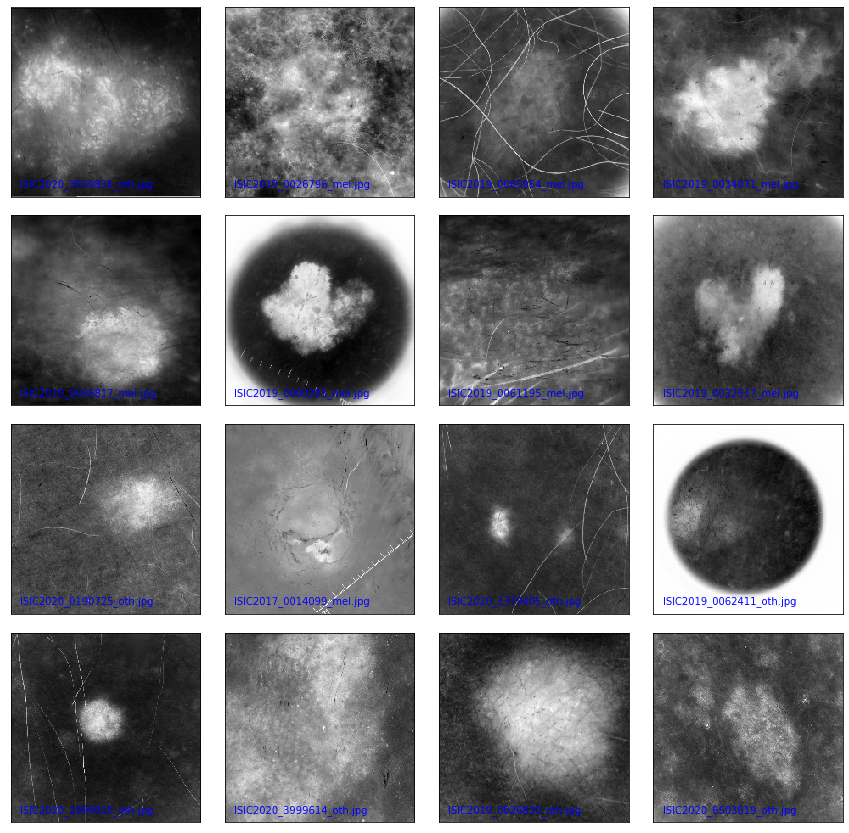

In [11]:
X = lesions_train.images
X_name = lesions_train.filenames

fig, axes = plt.subplots(4, 4, figsize=(15,15), subplot_kw={'xticks':[], 'yticks':[]}, 
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(X[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, X_name[i], transform=ax.transAxes, color='b')

In [12]:
lesions_train.data.shape

(7848, 50176)

In [13]:
lesions_train.target.shape

(7848,)

In [14]:
Xtrain = lesions_train.data
Xtest = lesions_test.data
ytrain = lesions_train.target
ytest = lesions_test.target

In [15]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(Xtrain, ytrain)
y_model = model.predict(Xtest)


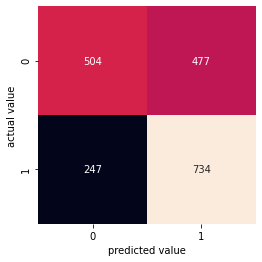

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(ytest, y_model)

sns.heatmap(mat, square = True, annot = True, cbar = False, fmt = 'g')
plt.xlabel('predicted value')
plt.ylabel('actual value');

In [17]:
#63% accuracy!